In [1]:
import zipfile
import numpy as np
import pandas as pd

import torch
from transformers import AutoProcessor, AutoModelForCTC
from torch.utils.data import Dataset

from IPython.display import clear_output
clear_output()

In [2]:
# set espeak library path for macOS
import sys
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

# Load Data

In [3]:
TIMIT2IPA = {'AA': 'ɑ', 'AE': 'æ', 'AH': 'ʌ', 'AH0': 'ə', 'AO': 'ɔ', 'AW': 'aʊ', 'AY': 'aɪ', 'EH': 'ɛ', 'ER': 'ɝ', 'ER0': 'ɚ', 'EY': 'eɪ', 'IH': 'ɪ', 'IH0': 'ɨ', 'IY': 'i', 'OW': 'oʊ', 'OY': 'ɔɪ', 'UH': 'ʊ', 'UW': 'u', 'B': '', 'CH': 'tʃ', 'D': '', 'DH': 'ð', 'EL': 'l̩', 'EM': 'm̩', 'EN': 'n̩', 'F': 'f', 'G': '', 'HH': 'h', 'JH': 'dʒ', 'K': '', 'L': 'l', 'M': 'm', 'N': 'n', 'NG': 'ŋ', 'P': '', 'Q': 'ʔ', 'R': 'ɹ', 'S': 's', 'SH': 'ʃ', 'T': '', 'TH': 'θ', 'V': 'v', 'W': 'w', 'WH': 'ʍ', 'Y': 'j', 'Z': 'z', 'ZH': 'ʒ', 'AX': 'ə', 'AX-H': 'ə̥', 'AXR': 'ɚ', 'BCL': 'b', 'DCL': 'd', 'DX': 'ɾ', 'ENG': 'ŋ̍', 'EPI': '', 'GCL': 'g', 'HV': 'ɦ', 'H#': '', 'IX': 'ɨ', 'KCL': 'k', 'NX': 'ɾ̃', 'PAU': '', 'PCL': 'p', 'TCL': 't', 'UX': 'ʉ'}
IPA_SUBSTITUTIONS = {
    'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
    'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
    'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
    'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'l̩': 'l',   # Remove syllabic marker from 'l̩'
    'm̩': 'm',   # Remove syllabic marker from 'm̩'
    'n̩': 'n',   # Remove syllabic marker from 'n̩'
    '̩': '',     # Remove syllabic marker
    'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
    'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
    ' ': '',     # Remove nasalization marker
    'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
}
for k in TIMIT2IPA.keys():
    if TIMIT2IPA[k] in IPA_SUBSTITUTIONS.keys():
        TIMIT2IPA[k] = IPA_SUBSTITUTIONS[TIMIT2IPA[k]]

In [4]:
DIALECTS = {
    1: 'New England',
    2: 'Northern',
    3: 'North Midland',
    4: 'South Midland',
    5: 'Southern',
    6: 'New York City',
    7: 'Western',
    8: 'Army Brat'
}

with zipfile.ZipFile('../.data/TIMIT.zip', 'r') as zip:
    print(zip.namelist())
    with zip.open('SPKRINFO.TXT') as file:
        # read as csv with ; indicating comment and double space as separator
        speakers = {}
        for line in file:
            line = line.decode('utf-8').strip()
            if not line.startswith(';'):
                parts = line.split('  ')
                speakers[parts[0]] = {
                    'SEX': parts[1],
                    'DIALECT': DIALECTS[int(parts[2])],
                    'SPLIT': parts[3],
                    'RECORDING_DATE': parts[4],
                    'BIRTH_DATE': parts[5],
                    'HEIGHT': parts[6],
                    'RACE': parts[7],
                    'EDUCATION': parts[8]
                }
                if len(parts) == 10:
                    speakers[parts[0]]['COMMENTS'] = parts[9]
    print(speakers)

['PHONCODE.DOC', 'PROMPTS.TXT', 'README.DOC', 'SPKRINFO.TXT', 'SPKRSENT.TXT', 'TESTSET.DOC', 'TIMITDIC.DOC', 'TIMITDIC.TXT', 'data/TEST/DR1/FAKS0/SA1.PHN', 'data/TEST/DR1/FAKS0/SA1.TXT', 'data/TEST/DR1/FAKS0/SA1.WAV', 'data/TEST/DR1/FAKS0/SA1.WAV.wav', 'data/TEST/DR1/FAKS0/SA1.WRD', 'data/TEST/DR1/FAKS0/SA2.PHN', 'data/TEST/DR1/FAKS0/SA2.TXT', 'data/TEST/DR1/FAKS0/SA2.WAV', 'data/TEST/DR1/FAKS0/SA2.WAV.wav', 'data/TEST/DR1/FAKS0/SA2.WRD', 'data/TEST/DR1/FAKS0/SI1573.PHN', 'data/TEST/DR1/FAKS0/SI1573.TXT', 'data/TEST/DR1/FAKS0/SI1573.WAV', 'data/TEST/DR1/FAKS0/SI1573.WAV.wav', 'data/TEST/DR1/FAKS0/SI1573.WRD', 'data/TEST/DR1/FAKS0/SI2203.PHN', 'data/TEST/DR1/FAKS0/SI2203.TXT', 'data/TEST/DR1/FAKS0/SI2203.WAV', 'data/TEST/DR1/FAKS0/SI2203.WAV.wav', 'data/TEST/DR1/FAKS0/SI2203.WRD', 'data/TEST/DR1/FAKS0/SI943.PHN', 'data/TEST/DR1/FAKS0/SI943.TXT', 'data/TEST/DR1/FAKS0/SI943.WAV', 'data/TEST/DR1/FAKS0/SI943.WAV.wav', 'data/TEST/DR1/FAKS0/SI943.WRD', 'data/TEST/DR1/FAKS0/SX133.PHN', 'data/T

In [5]:
speakers.keys()

dict_keys(['ABC0', 'ABW0', 'ADC0', 'ADD0', 'ADG0', 'AEB0', 'AEM0', 'AEO0', 'AFM0', 'AHH0', 'AJC0', 'AJP0', 'AJW0', 'AKB0', 'AKR0', 'AKS0', 'ALK0', 'ALR0', 'APB0', 'APV0', 'ARC0', 'ARW0', 'ASW0', 'AWF0', 'BAR0', 'BAS0', 'BBR0', 'BCG0', 'BCG1', 'BCH0', 'BDG0', 'BEF0', 'BGT0', 'BJK0', 'BJL0', 'BJV0', 'BLV0', 'BMA0', 'BMA1', 'BMH0', 'BMJ0', 'BML0', 'BNS0', 'BOM0', 'BPM0', 'BSB0', 'BTH0', 'BWM0', 'BWP0', 'CAE0', 'CAG0', 'CAJ0', 'CAL0', 'CAL1', 'CAU0', 'CCS0', 'CDC0', 'CDD0', 'CDR0', 'CDR1', 'CEF0', 'CEG0', 'CEM0', 'CEW0', 'CFT0', 'CHH0', 'CHL0', 'CJF0', 'CJS0', 'CKE0', 'CLK0', 'CLM0', 'CLT0', 'CMB0', 'CMG0', 'CMH0', 'CMH1', 'CMJ0', 'CMM0', 'CMR0', 'CPM0', 'CRC0', 'CRE0', 'CRH0', 'CRZ0', 'CSH0', 'CSS0', 'CTH0', 'CTM0', 'CTT0', 'CTW0', 'CXM0', 'CYL0', 'DAB0', 'DAC0', 'DAC1', 'DAC2', 'DAS0', 'DAS1', 'DAW0', 'DAW1', 'DBB0', 'DBB1', 'DBP0', 'DCD0', 'DCM0', 'DDC0', 'DED0', 'DEF0', 'DEM0', 'DFB0', 'DHC0', 'DHL0', 'DHS0', 'DJH0', 'DJM0', 'DKN0', 'DKS0', 'DLB0', 'DLC0', 'DLC1', 'DLC2', 'DLD0', 'DLF0

In [6]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/arunasrivastava/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
from collections import OrderedDict
WAV_HEADER_SIZE = 44
from g2p_en import G2p
g2p = G2p()

import sys
sys.path.append('../')

from scripts.core.codes import arpabet2ipa
class TIMITDataset(Dataset):
    def __init__(self, split="train", include_timestamps=False, include_speaker_info=False):
        self.zip = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
        files = self.zip.namelist()
        self.files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/' + split.upper()), files))))
        self.include_timestamps = include_timestamps
        self.include_speaker_info = include_speaker_info

    def __del__(self):
        self.zip.close()

    def __len__(self):
        return len(self.files)

    def _get_file(self, filename):
        speaker_id = filename.split('/')[-2][-4:]
        speaker = speakers[speaker_id]

        with self.zip.open(filename + '.WAV') as wav_file:
            audio = np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

        with self.zip.open(filename + '.PHN') as phn_file:
            timestamped_phonemes = []
            for line in phn_file.read().decode('utf-8').split('\n'):
                if line == '':
                    continue
                start, end, phoneme = line.split()
                ipa_phonemes = TIMIT2IPA.get(phoneme.upper(), '<unk>')
                timestamped_phonemes.append((ipa_phonemes, int(start), int(end)))
        ipa = ''.join([x[0] for x in timestamped_phonemes])

        # grab text transcripts 
        with self.zip.open(filename + '.TXT') as txt_file:
            text = ' '.join(txt_file.read().decode('utf-8').strip().split(' ')[2:])
            text = text.replace('.', '').replace(',','').replace('!','').replace('?','').replace(':','').replace(';','').replace('(','').replace(')','').replace('"','').replace("'",'').replace('-','').replace('  ',' ')
            g2p_arpa_text = g2p(text)
            # remove stress markers
            g2p_ipa = ''.join(map(arpabet2ipa,g2p_arpa_text)).replace('ˈ', '').replace('ˌ', '')


            
        start_signal = timestamped_phonemes.pop(0)
        audio = audio[start_signal[2]:]
        timestamped_phonemes = [(x[0], x[1] - start_signal[2], x[2] - start_signal[2]) for x in timestamped_phonemes]
        
        result = OrderedDict()
        result['ipa'] = ipa
        result['audio'] = audio
        result['phonemes'] = timestamped_phonemes
        result['speaker'] = speaker
        result['text'] = text
        result['g2p-text'] = g2p_ipa
        
        if not self.include_timestamps:
            del result['phonemes']
        if not self.include_speaker_info:
            del result['speaker']
        return tuple(result.values())

    def __getitem__(self, index):
        filenames = self.files[index]
        if isinstance(filenames, str):
            return self._get_file(filenames)
        else:
            return [self._get_file(filename) for filename in filenames]

In [8]:
train = TIMITDataset("train", include_speaker_info=True)
test = TIMITDataset("test", include_speaker_info=True)

In [9]:
print(test[0])

('lizteɪkðɪsdɹɾiteɪblklɔθtəðikliɾɹʒfɹmi', array([ 2,  3, -1, ...,  1,  2,  0], dtype=int16), {'SEX': 'M', 'DIALECT': 'North Midland', 'SPLIT': 'TST', 'RECORDING_DATE': '03/11/86', 'BIRTH_DATE': '04/30/58', 'HEIGHT': '5\'11"', 'RACE': 'WHT', 'EDUCATION': 'MS'}, 'Please take this dirty table cloth to the cleaners for me', 'plizteɪkðɪsdɝtiteɪbʌlklɔθtuðʌklinɝzfɔɹmi')


('ʃihædjɹdɑɹksuɾiŋgɹisiwɑʃwɔɾɹɔljɪɹ', array([-1,  2,  3, ...,  3,  3,  0], dtype=int16), {'SEX': 'M', 'DIALECT': 'Western', 'SPLIT': 'TRN', 'RECORDING_DATE': '03/31/86', 'BIRTH_DATE': '12/22/52', 'HEIGHT': '5\'08"', 'RACE': 'WHT', 'EDUCATION': 'BS'}, 'She had your dark suit in greasy wash water all year', 'ʃihædjɔɹdɑɹksutɪnɡɹisiwɑʃwɔtɝɔljɪɹ')


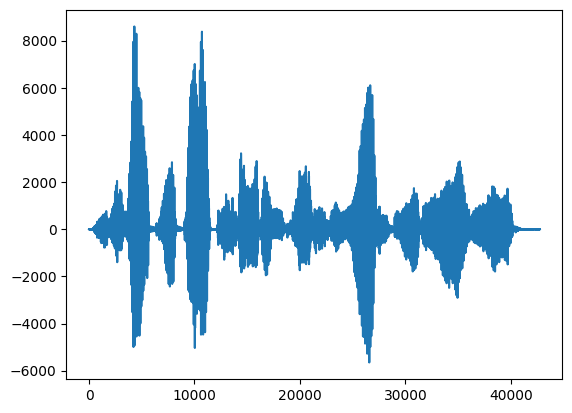

In [10]:
import matplotlib.pyplot as plt
print(train[0])
plt.plot(train[0][1])
plt.show()

# Eval

In [11]:
SAMPLE_RATE = 16000
def transcribe_batch(batch):
    input_values = processor([x[1] for x in batch], sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True).input_values.type(torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return [processor.decode(ids) for ids in predicted_ids]

In [12]:
import panphon.distance

def cer(prediction, ground_truth):
    # Convert input lists to strings if they're lists
    if isinstance(prediction, list):
        prediction = "".join(prediction)
    if isinstance(ground_truth, list):
        ground_truth = "".join(ground_truth)

    # Handle empty strings
    if len(ground_truth) == 0:
        return 1.0 if len(prediction) > 0 else 0.0

    # Initialize the matrix
    matrix = np.zeros((len(prediction) + 1, len(ground_truth) + 1))

    # Fill first row and column
    for i in range(len(prediction) + 1):
        matrix[i, 0] = i
    for j in range(len(ground_truth) + 1):
        matrix[0, j] = j

    # Fill in the rest of the matrix
    for i in range(1, len(prediction) + 1):
        for j in range(1, len(ground_truth) + 1):
            if prediction[i - 1] == ground_truth[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                substitution = matrix[i - 1, j - 1] + 1
                insertion = matrix[i, j - 1] + 1
                deletion = matrix[i - 1, j] + 1
                matrix[i, j] = min(substitution, insertion, deletion)

    # Calculate CER
    distance = matrix[len(prediction), len(ground_truth)]
    return distance / len(ground_truth)


def preprocess_ipa(ipa_string):
    """Preprocess an IPA string by removing unsupported symbols. Suggestions by David Mortensen, creator of panphon."""
    replacement_map = {
        "ɚ": "ɹ̩",  # Convert /ɚ/ to /ɹ/ (non-syllabic r)
        "ɝ": "ɹ",  # Convert /ɝ/ to /ɹ/ (non-syllabic r)
        "ː": "",  # Remove length mark (or duplicate previous vowel if length is important)
        "͡": "",  # Remove tie bar (or split into components if part of an affricate)
        "g": "ɡ",  # replace two versions of g, TIMIT uses ascii g and STANDARD IPA uses unicode g
    }
    processed_string = "".join(replacement_map.get(char, char) for char in ipa_string)

    return processed_string


def panphon_model_eval(label, predicted):
    label_sequence = preprocess_ipa(label)
    pred_sequence = preprocess_ipa(predicted)

    weighted_feature_dist = panphon.distance.Distance().weighted_feature_edit_distance(
        label_sequence, pred_sequence
    )
    cer_score = cer(predicted, label)

    return cer_score, weighted_feature_dist

In [13]:
# print first row of test df
print(test[0])

('lizteɪkðɪsdɹɾiteɪblklɔθtəðikliɾɹʒfɹmi', array([ 2,  3, -1, ...,  1,  2,  0], dtype=int16), {'SEX': 'M', 'DIALECT': 'North Midland', 'SPLIT': 'TST', 'RECORDING_DATE': '03/11/86', 'BIRTH_DATE': '04/30/58', 'HEIGHT': '5\'11"', 'RACE': 'WHT', 'EDUCATION': 'MS'}, 'Please take this dirty table cloth to the cleaners for me', 'plizteɪkðɪsdɝtiteɪbʌlklɔθtuðʌklinɝzfɔɹmi')


In [14]:
import torch
import pandas as pd

# Set the device to CUDA if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Initialize the scores DataFrame
scores = pd.DataFrame(columns=['Dialect', 'Gender', 'Race', 'Education', 'CER', 'FER', 'Ground Truth', 'Prediction'])

# Define batch size
BATCH_SIZE = 32

# Iterate through the test dataset in batches
for batch_start in range(0, len(test), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(test))
    batch = test[batch_start:batch_end]
    
    for item in batch:
        # Comparing the TIMIT phonetics to g2p phonetics
        phonetic_transcript = item[0]
        g2p_transcript = item[-1]

        timit_vocab_freq = {}
        g2p_vocab_freq = {}

        # Add both transcripts to a vocab frequency dictionary to track phoneme counts 
        for phoneme in phonetic_transcript:
            if phoneme in timit_vocab_freq:
                timit_vocab_freq[phoneme] += 1
            else:
                timit_vocab_freq[phoneme] = 1
        for phoneme in g2p_transcript:
            if phoneme in g2p_vocab_freq:
                g2p_vocab_freq[phoneme] += 1
            else:
                g2p_vocab_freq[phoneme] = 1
        
        phonetic_transcript = phonetic_transcript.to(DEVICE) if isinstance(phonetic_transcript, torch.Tensor) else phonetic_transcript
        g2p_transcript = g2p_transcript.to(DEVICE) if isinstance(g2p_transcript, torch.Tensor) else g2p_transcript
        
        # Evaluate CER and feature distance
        cer_score, feature_distance = panphon_model_eval(phonetic_transcript, g2p_transcript)
        
        # Append results to the scores DataFrame
        scores = pd.concat([scores, pd.DataFrame([[
            item[2]['DIALECT'],
            item[2]['SEX'],
            item[2]['RACE'],
            item[2]['EDUCATION'],
            cer_score, 
            feature_distance,
            ''.join(phonetic_transcript),  # Ground Truth
            ''.join(g2p_transcript)       # Prediction
        ]], columns=scores.columns)])

# Print the results
print(f"CER: {scores['CER'].mean()} (std: {scores['CER'].std()})")
print(f"FER: {scores['FER'].mean()} (std: {scores['FER'].std()})")

# Print the dictionaries
print(timit_vocab_freq)
print(g2p_vocab_freq)

/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


CER: 0.2895763153314864 (std: 0.08812410582887935)
FER: 26.198995535714285 (std: 14.244572523893279)
{'ɪ': 3, 'l': 2, 'i': 1, 't': 1, 'ɛ': 4, 'ɹ': 7, 'p': 2, 's': 3, 'n': 1, 'ɑ': 1, 'k': 2, 'd': 1, 'u': 1, 'o': 1, 'ʊ': 1, 'b': 1, 'e': 1, 'g': 1, 'ʌ': 1, 'v': 1, 'm': 1, 'ɾ': 2, 'ɔ': 1}
{'m': 2, 'ɪ': 3, 'l': 2, 'ʌ': 5, 't': 4, 'ɛ': 3, 'ɹ': 3, 'i': 1, 'p': 2, 'ɝ': 3, 's': 2, 'n': 2, 'ɑ': 1, 'k': 2, 'd': 2, 'u': 1, 'o': 1, 'ʊ': 1, 'b': 1, 'e': 1, 'ɡ': 1, 'v': 1, 'ɔ': 1, 'z': 1}


In [20]:
# calculate the frequency distribution of phonemes in the ground truth and predicted transcriptions from scores
from collections import Counter
from scripts.eval.evaluate import simplify_ipa

def phoneme_distribution(scores, column, model, dataset):
    phoneme_counter = Counter()
    for i, row in scores[(scores['Model'] == model) & (scores['Dataset'] == dataset)].iterrows():
        phoneme_counter.update(simplify_ipa(row[column]).replace(' ', ''))

    return phoneme_counter

phon_dist = pd.DataFrame(columns=['Dataset', 'Phoneme', 'Frequency'])
for dataset in scores['Dataset'].unique():
    phon_dist = pd.concat([phon_dist, pd.DataFrame([
        [dataset, phoneme, freq]
        for phoneme, freq in phoneme_distribution(scores, 'Ground Truth', scores['Model'][0], dataset).items()
    ], columns=phon_dist.columns)])

phon_dist_by_model = pd.DataFrame(columns=['Model', 'Dataset', 'Phoneme', 'Frequency'])
for model in scores['Model'].unique():
    for dataset in scores['Dataset'].unique():
        phon_dist_by_model = pd.concat([phon_dist_by_model, pd.DataFrame([
            [model, dataset, phoneme, freq]
            for phoneme, freq in phoneme_distribution(scores, 'Prediction', model, dataset).items()
        ], columns=phon_dist_by_model.columns)])

# Plot the frequency distribution of phonemes in the ground truth
plt.figure(figsize=(20, 6))
plt.suptitle('Frequency distribution of phonemes in the ground truth transcriptions')
for i, dataset in enumerate(phon_dist['Dataset'].unique()):
    plt.subplot(1, 2, i + 1)
    data = phon_dist[phon_dist['Dataset'] == dataset]
    data = data.sort_values('Frequency', ascending=False)
    plt.bar(data['Phoneme'], data['Frequency'])
    plt.title(dataset)
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
plt.show()

# Plot the frequency distribution of phonemes in the g2p transcriptions
plt.figure(figsize=(20, 6))
plt.suptitle('Frequency distribution of phonemes in the g2p transcriptions')
for i, model in enumerate(phon_dist_by_model['Model'].unique()):
    plt.subplot(1, 3, i + 1)
    for dataset in phon_dist_by_model['Dataset'].unique():
        data = phon_dist_by_model[(phon_dist_by_model['Model'] == model) & (phon_dist_by_model['Dataset'] == dataset)]
        data = data.sort_values('Frequency', ascending=False)
        plt.bar(data['Phoneme'], data['Frequency'], label=dataset, alpha=0.7)
    plt.title(model)
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

KeyError: 'Dataset'

In [18]:
from scripts.forced_alignment.needleman_wunsch import weighted_needleman_wunsch
from scripts.core.ipa import remove_length_diacritics
from scripts.forced_alignment.common import group_phonemes
from zipfile import ZipFile as ZipFileObject

scores.reset_index(drop=True, inplace=True)
scores = scores.loc[:, ~scores.columns.str.contains('->')] # drop all columns with -> in the name
for i, row in scores.iterrows():
    missed_phoneme_pairs = {}
    norm_label, norm_pred = group_phonemes(remove_length_diacritics(row['Ground Truth']).replace(' ', '')), group_phonemes(remove_length_diacritics(row['Prediction']).replace(' ', ''))
    for pair in zip(*weighted_needleman_wunsch(norm_label, norm_pred)):
        if pair[0] != pair[1]:
            missed_phoneme_pairs[pair] = missed_phoneme_pairs.get(pair, 0) + 1
    # add each phoneme pair as a column to the scores dataframe
    for pair, count in missed_phoneme_pairs.items():
        col = f'{pair[0]}->{pair[1]}'
        if col not in scores.columns:
            scores[col] = 0
        col_index = scores.columns.get_loc(col)
        scores.iat[i, col_index] = count
clear_output()

TypeError: unhashable type: 'list'

In [43]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
BATCH_SIZE = 4
scores = pd.DataFrame(columns=['Model', 'Dialect', 'Gender', 'Race', 'Education', 'CER', 'FER'])
for name, model_id in [
    # ("KoelLabs a1", "KoelLabs/xlsr-timit-a1"),
    ("KoelLabs b0", "KoelLabs/xlsr-timit-b0"),
    # ("KoelLabs c0", "KoelLabs/xlsr-timit-c0"),
    # ("KoelLabs d0", "KoelLabs/xlsr-timit-d0"),
    # ("KoelLabs e0", "KoelLabs/xlsr-timit-e0"),
    # ("KoelLabs b1", "KoelLabs/xlsr-timit-b1"),
    # ("KoelLabs c1", "KoelLabs/xlsr-timit-c1"),
    # ("KoelLabs d1", "KoelLabs/xlsr-timit-d1"),
    # ("KoelLabs e1", "KoelLabs/xlsr-timit-e1"),
    ("Taguchi", "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"),
    # ("Rubino", "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"),
    # ("Facebook", "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    # ("Vitouphy", "vitouphy/wav2vec2-xls-r-300m-timit-phoneme")
]:
    print(f"Model: {name} ({model_id})")
    torch.mps.empty_cache()
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForCTC.from_pretrained(model_id).to(DEVICE)

    amount = len(test)
    for i in range(0, amount, BATCH_SIZE):
        torch.mps.empty_cache()
        size = min(BATCH_SIZE, amount - i)
        transcriptions = transcribe_batch([test[i+j] for j in range(size)])
        for j in range(size):
            cer_score, feature_distance = panphon_model_eval(test[i+j][0], transcriptions[j])
            scores = pd.concat([scores, pd.DataFrame([[
                name, 
                test[i+j][2]['DIALECT'],
                test[i+j][2]['SEX'],
                test[i+j][2]['RACE'],
                test[i+j][2]['EDUCATION'],
                cer_score, 
                feature_distance,
            ]], columns=scores.columns)])

    print(f"CER: {scores['CER'].mean()} (std: {scores['CER'].std()})")
    print(f"FER: {scores['FER'].mean()} (std: {scores['FER'].std()})")

Model: Facebook (facebook/wav2vec2-lv-60-espeak-cv-ft)


/Users/alex/Desktop/CS/Startups/Koel/ML/venv/lib/python3.8/site-packages/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


CER: 0.5443275892695532 (std: 0.5059153977376667)
FER: 21.269283234126984 (std: 14.488049758562925)


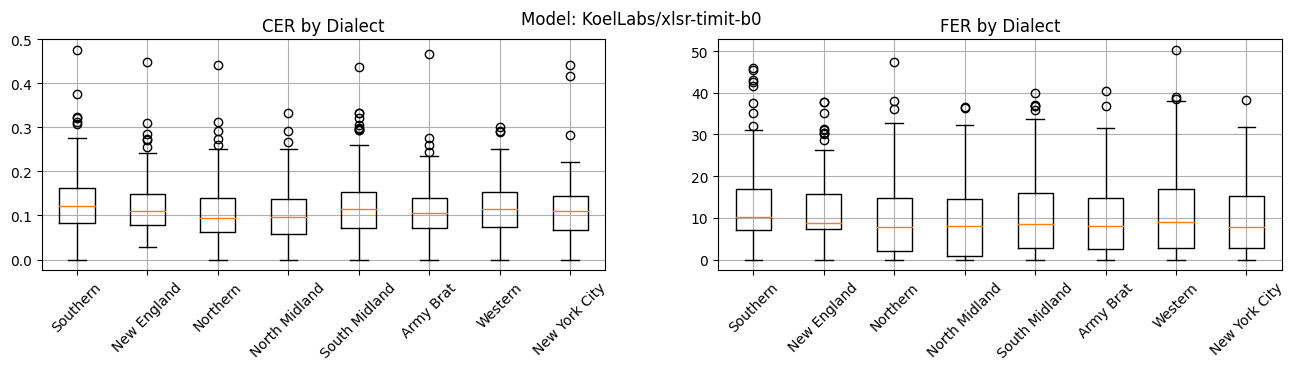

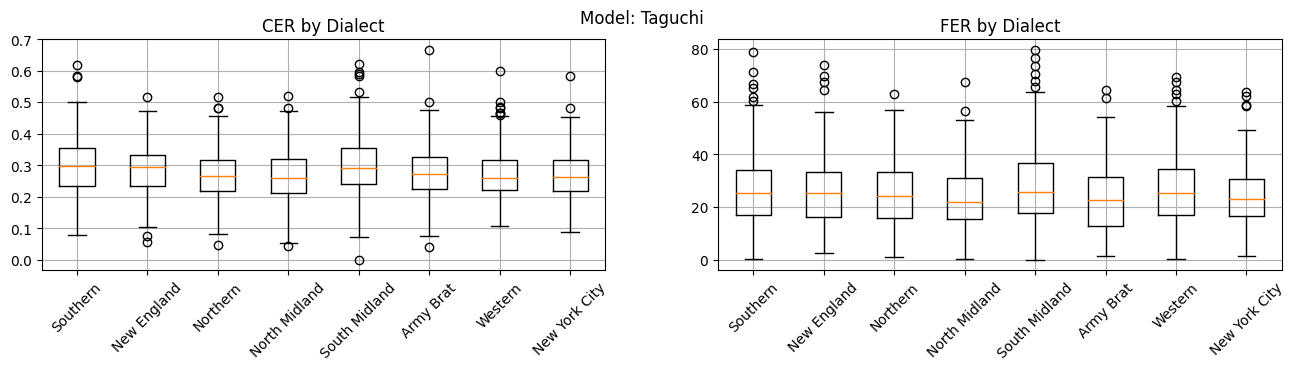

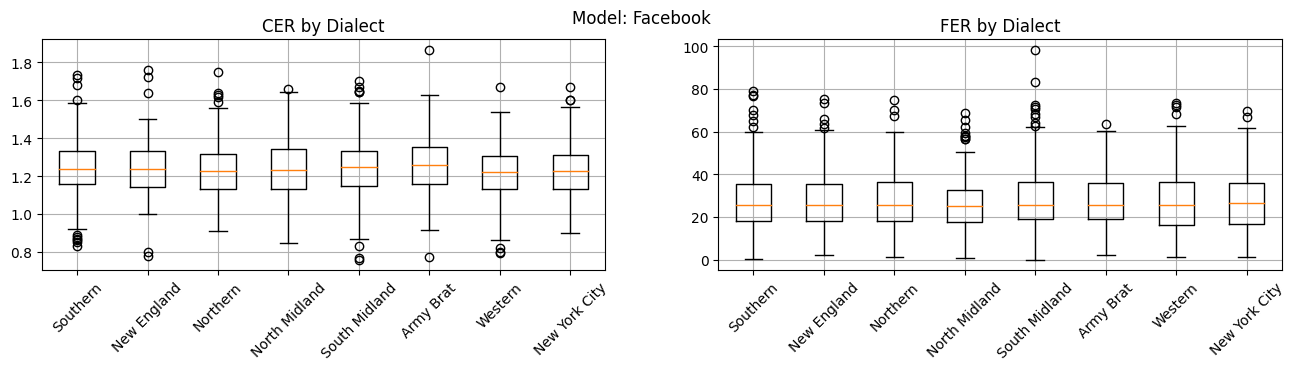

In [84]:
# boxplot of CER and FER by dialect and model
dialects = scores['Dialect'].unique()
# dialects = [DIALECTS[2], DIALECTS[5]]
for model in scores['Model'].unique():
    plt.figure(figsize=(16, 3))
    plt.suptitle(f"Model: {model}")
    plt.subplot(1, 2, 1)
    plt.title('CER by Dialect')
    plt.xticks(rotation=45)
    plt.grid()
    plt.boxplot([scores[(scores['Dialect'] == dialect) & (scores['Model'] == model)]['CER'] for dialect in dialects], labels=dialects)
    plt.subplot(1, 2, 2)
    plt.title('FER by Dialect')
    plt.xticks(rotation=45)
    plt.grid()
    plt.boxplot([scores[(scores['Dialect'] == dialect) & (scores['Model'] == model)]['FER'] for dialect in dialects], labels=dialects)
    plt.show()

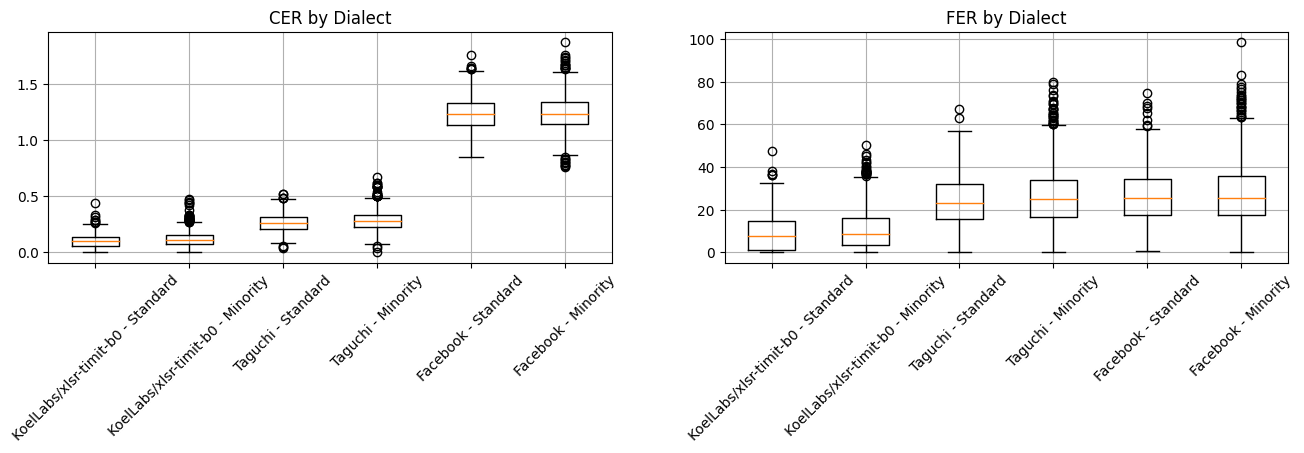

In [45]:
STANDARD_DIALECTS = ['Northern', 'North Midland']
MINORITY_DIALECTS = [d for d in scores['Dialect'].unique() if d not in STANDARD_DIALECTS]

labels = [f"{m} - {d}" for m in scores['Model'].unique() for d in ['Standard', 'Minority']]

plt.figure(figsize=(16, 3))
plt.suptitle(f"")
plt.subplot(1, 2, 1)
plt.title('CER by Dialect')
plt.xticks(rotation=45)
plt.grid()
plt.boxplot([
    scores[(scores['Dialect'].isin(dialect_type)) & (scores['Model'] == model)]['CER']
    for model in scores['Model'].unique()
    for dialect_type in [STANDARD_DIALECTS, MINORITY_DIALECTS]
], labels=labels)
plt.subplot(1, 2, 2)
plt.title('FER by Dialect')
plt.xticks(rotation=45)
plt.grid()
plt.boxplot([
    scores[(scores['Dialect'].isin(dialect_type)) & (scores['Model'] == model)]['FER']
    for model in scores['Model'].unique()
    for dialect_type in [STANDARD_DIALECTS, MINORITY_DIALECTS]
], labels=labels)
plt.show()

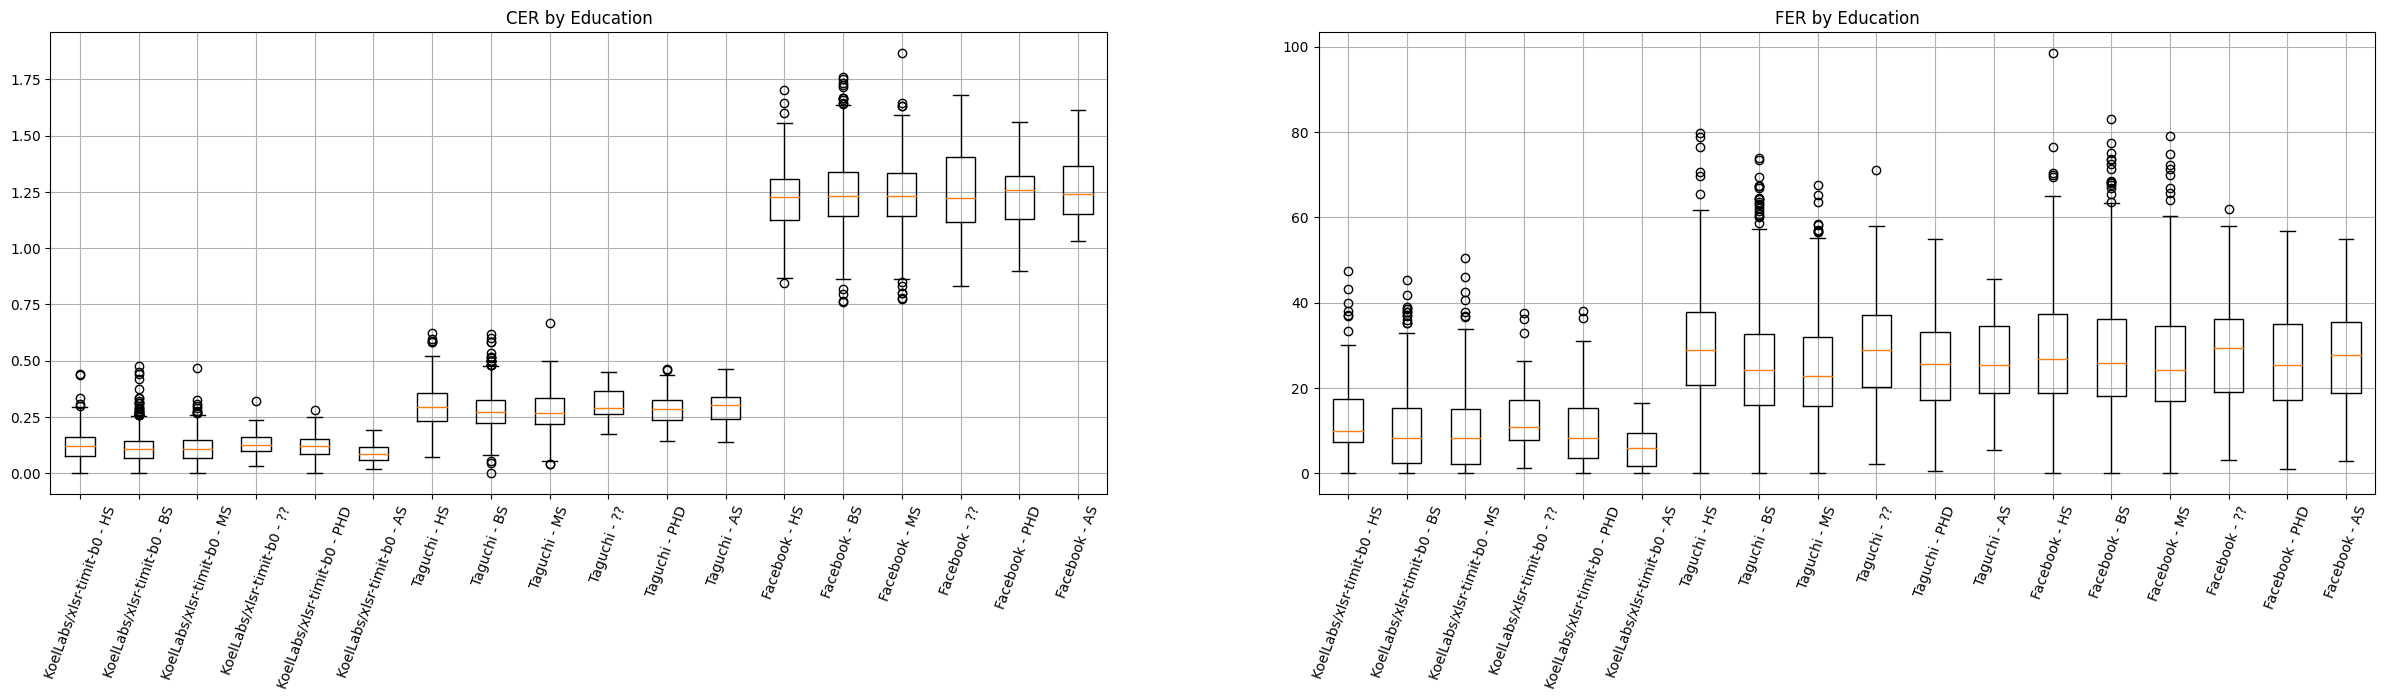

In [58]:
# boxplots by model by X
# X = 'Gender'
X = 'Education'
labels = [f"{m} - {d}" for m in scores['Model'].unique() for d in scores[X].unique()]

plt.figure(figsize=(30, 6))
plt.suptitle(f"")
plt.subplot(1, 2, 1)
plt.title('CER by ' + X)
plt.xticks(rotation=70)
plt.grid()
plt.boxplot([
    scores[(scores[X].isin(typ)) & (scores['Model'] == model)]['CER']
    for model in scores['Model'].unique()
    for typ in [[s] for s in scores[X].unique()]
], labels=labels)
plt.subplot(1, 2, 2)
plt.title('FER by ' + X)
plt.xticks(rotation=70)
plt.grid()
plt.boxplot([
    scores[(scores[X].isin(typ)) & (scores['Model'] == model)]['FER']
    for model in scores['Model'].unique()
    for typ in [[s] for s in scores[X].unique()]
], labels=labels)
plt.show()

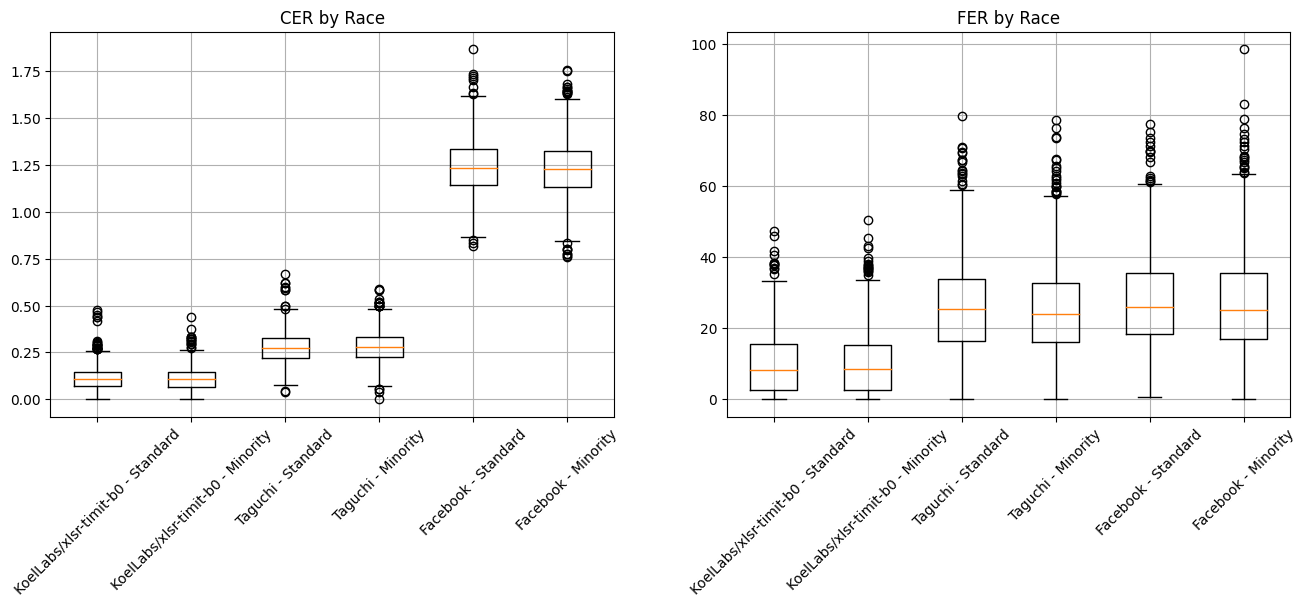

In [60]:
STANDARD_RACE = ['WHT']
MINORITY_RACE = [d for d in scores['Race'].unique() if d not in STANDARD_RACE]

labels = [f"{m} - {d}" for m in scores['Model'].unique() for d in ['Standard', 'Minority']]

plt.figure(figsize=(16, 5))
plt.suptitle(f"")
plt.subplot(1, 2, 1)
plt.title('CER by Race')
plt.xticks(rotation=45)
plt.grid()
plt.boxplot([
    scores[(scores['Race'].isin(dialect_type)) & (scores['Model'] == model)]['CER']
    for model in scores['Model'].unique()
    for dialect_type in [STANDARD_RACE, MINORITY_RACE]
], labels=labels)
plt.subplot(1, 2, 2)
plt.title('FER by Race')
plt.xticks(rotation=45)
plt.grid()
plt.boxplot([
    scores[(scores['Race'].isin(dialect_type)) & (scores['Model'] == model)]['FER']
    for model in scores['Model'].unique()
    for dialect_type in [STANDARD_RACE, MINORITY_RACE]
], labels=labels)
plt.show()

In [63]:
scores[['Model', 'CER', 'FER']].groupby('Model').mean()

,CER,FER
Model,,
Facebook,1.237258,27.601116
KoelLabs/xlsr-timit-b0,0.114491,10.535193
Taguchi,0.281234,25.671540


In [64]:
scores[['Dialect', 'CER', 'FER']].groupby('Dialect').mean()

,CER,FER
Dialect,,
Army Brat,0.550914,20.385227
New England,0.549820,22.070455
New York City,0.536524,20.724053
North Midland,0.534100,19.214183
Northern,0.535889,20.487580
South Midland,0.554525,22.372982
Southern,0.557506,22.360491
Western,0.533153,21.912500


In [65]:
scores[['Gender', 'CER', 'FER']].groupby('Gender').mean()

,CER,FER
Gender,,
F,0.540373,21.414323
M,0.546305,21.196763


In [66]:
scores[['Race', 'CER', 'FER']].groupby('Race').mean()

,CER,FER
Race,,
???,0.536032,19.913889
BLK,0.552611,23.350347
WHT,0.541948,20.860907
???,0.560535,23.643750
BLK,0.552424,24.450000
ORN,0.498800,19.612500
WHT,0.547050,21.543750


In [67]:
scores[['Education', 'CER', 'FER']].groupby('Education').mean()

,CER,FER
Education,,
??,0.560614,24.670139
AS,0.552557,20.195833
BS,0.545176,21.161195
HS,0.549820,23.818750
MS,0.539441,20.296354
PHD,0.544758,20.979167


In [79]:
scores[['Model', 'Education', 'CER', 'FER']].groupby(['Model', 'Education']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

CER                       FER  \
                                      mean       std    n       mean   
Model                  Education                                       
Facebook               ??         1.242763  0.208615   30  29.597917   
                       AS         1.271499  0.157015   20  28.375000   
                       BS         1.242935  0.149631  830  27.919352   
                       HS         1.220927  0.147257  210  29.250000   
                       MS         1.234297  0.145221  520  26.418029   
                       PHD        1.228790  0.131168   70  26.592857   
KoelLabs/xlsr-timit-b0 ??         0.131798  0.060698   30  14.487500   
                       AS         0.089311  0.046364   20   6.231250   
                       BS         0.113112  0.064138  830  10.383057   
                       HS         0.127029  0.071629  210  12.128571   
                       MS         0.110703  0.059838  520  10.064423   
                       PHD        0.121128  0.056620   70  10.591964   
Taguchi                ??         0.307282  0.076928   30  29.925000   
                       AS         0.296863  0.079152   20  25.981250   
                       BS         0.279480  0.084527  830  25.181175   
                       HS         0.301504  0.100847  210  30.077679   
                       MS         0.273324  0.084118  520  24.406611   
                       PHD        0.284356  0.074844   70  25.752679   

                                                  
                                        std    n  
Model                  Education                  
Facebook               ??         14.129135   30  
                       AS         12.775114   20  
                       BS         14.084474  830  
                       HS         14.917419  210  
                       MS         13.677419  520  
                       PHD        13.190999   70  
KoelLabs/xlsr-timit-b0 ??          9.101253   30  
                       AS          5.371139   20  
                       BS          8.677458  830  
                       HS          9.561292  210  
                       MS          8.626214  520  
                       PHD         9.059084   70  
Taguchi                ??         15.203951   30  
                       AS         10.607069   20  
                       BS         13.280005  830  
                       HS         14.566851  210  
                       MS         13.009793  520  
                       PHD        12.355205   70

In [81]:
scores[['Model', 'Gender', 'CER', 'FER']].groupby(['Model', 'Gender']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

CER                        FER             \
                                   mean       std     n       mean        std   
Model                  Gender                                                   
Facebook               F       1.226714  0.140682   560  27.721429  13.672424   
                       M       1.242530  0.152184  1120  27.540960  14.212189   
KoelLabs/xlsr-timit-b0 F       0.112818  0.060610   560  10.228683   8.431766   
                       M       0.115327  0.064952  1120  10.688449   8.990478   
Taguchi                F       0.281586  0.085745   560  26.292857  13.706227   
                       M       0.281058  0.086823  1120  25.360882  13.304785   

                                     
                                  n  
Model                  Gender        
Facebook               F        560  
                       M       1120  
KoelLabs/xlsr-timit-b0 F        560  
                       M       1120  
Taguchi                F        560  
                       M       1120

In [80]:
scores[['Model', 'Race', 'CER', 'FER']].groupby(['Model', 'Race']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

CER                       FER             \
                                 mean       std    n       mean        std   
Model                  Race                                                  
Facebook                ???  1.229843  0.159666   30  25.389583  13.483054   
                        BLK  1.220073  0.167392   60  27.787500  13.828719   
                        WHT  1.232551  0.149137  850  27.284779  14.227860   
                       ???   1.230386  0.220512   10  26.443750  19.731497   
                       BLK   1.245501  0.073382   20  29.365625  13.294400   
                       ORN   1.194389  0.183885   10  29.668750  14.847607   
                       WHT   1.245239  0.145754  700  28.000625  13.783630   
KoelLabs/xlsr-timit-b0  ???  0.106895  0.064699   30  10.133333   8.596385   
                        BLK  0.137429  0.066097   60  14.366667   9.805527   
                        WHT  0.111604  0.059946  850  10.268382   8.509361   
                       ???   0.152234  0.090411   10  14.875000  10.689794   
                       BLK   0.116139  0.057945   20  11.712500  11.206355   
                       ORN   0.073497  0.050402   10   5.250000   6.956462   
                       WHT   0.116355  0.066729  700  10.527857   8.925482   
Taguchi                 ???  0.271357  0.105444   30  24.218750  14.106094   
                        BLK  0.300331  0.090229   60  27.896875  14.274695   
                        WHT  0.281689  0.084871  850  25.029559  13.039268   
                       ???   0.298986  0.084155   10  29.612500   9.797551   
                       BLK   0.295633  0.078621   20  32.271875  16.764125   
                       ORN   0.228514  0.108455   10  23.918750  13.843152   
                       WHT   0.279556  0.086896  700  26.102768  13.713414   

                                  
                               n  
Model                  Race       
Facebook                ???   30  
                        BLK   60  
                        WHT  850  
                       ???    10  
                       BLK    20  
                       ORN    10  
                       WHT   700  
KoelLabs/xlsr-timit-b0  ???   30  
                        BLK   60  
                        WHT  850  
                       ???    10  
                       BLK    20  
                       ORN    10  
                       WHT   700  
Taguchi                 ???   30  
                        BLK   60  
                        WHT  850  
                       ???    10  
                       BLK    20  
                       ORN    10  
                       WHT   700

In [78]:
scores[['Model', 'Dialect', 'CER', 'FER']].groupby(['Model', 'Dialect']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

CER                       FER  \
                                          mean       std    n       mean   
Model                  Dialect                                             
Facebook               Army Brat      1.262756  0.159078  110  27.984659   
                       New England    1.243065  0.154522  110  28.228977   
                       New York City  1.227976  0.148051  110  27.357386   
                       North Midland  1.238454  0.142470  260  25.585817   
                       Northern       1.235237  0.145385  260  27.299519   
                       South Midland  1.242270  0.151648  320  28.742969   
                       Southern       1.244861  0.151292  280  27.977009   
                       Western        1.211428  0.141807  230  27.806793   
KoelLabs/xlsr-timit-b0 Army Brat      0.112403  0.064293  110   9.575000   
                       New England    0.123039  0.067443  110  11.878977   
                       New York City  0.112767  0.067985  110  10.289205   
                       North Midland  0.100209  0.056486  260   8.898077   
                       Northern       0.103611  0.058195  260   9.296875   
                       South Midland  0.120202  0.065324  320  10.657422   
                       Southern       0.128908  0.067530  280  12.203571   
                       Western        0.115170  0.060131  230  11.518750   
Taguchi                Army Brat      0.277584  0.094197  110  23.596023   
                       New England    0.283355  0.082656  110  26.103409   
                       New York City  0.268829  0.082163  110  24.525568   
                       North Midland  0.263638  0.084255  260  23.158654   
                       Northern       0.268819  0.079213  260  24.866346   
                       South Midland  0.301103  0.090197  320  27.718555   
                       Southern       0.298748  0.090423  280  26.900893   
                       Western        0.272859  0.077901  230  26.411957   

                                                      
                                            std    n  
Model                  Dialect                        
Facebook               Army Brat      13.639701  110  
                       New England    15.497145  110  
                       New York City  14.201080  110  
                       North Midland  13.050326  260  
                       Northern       13.164617  260  
                       South Midland  14.259609  320  
                       Southern       14.777737  280  
                       Western        14.125342  230  
KoelLabs/xlsr-timit-b0 Army Brat       8.239719  110  
                       New England     9.048830  110  
                       New York City   8.635011  110  
                       North Midland   7.926233  260  
                       Northern        8.393006  260  
                       South Midland   8.566838  320  
                       Southern        9.338069  280  
                       Western         9.610265  230  
Taguchi                Army Brat      13.313954  110  
                       New England    14.214502  110  
                       New York City  12.112258  110  
                       North Midland  12.670492  260  
                       Northern       12.644676  260  
                       South Midland  13.952386  320  
                       Southern       14.083732  280  
                       Western        13.431784  230